In [1]:
import sys
import os
import numpy
numpy.seterr(all='raise')
from PIL import Image
from math import cos,sin,sqrt,pi
from fractions import Fraction
from ipywidgets import interact, interactive, widgets, Layout, Box, HBox, VBox
from IPython.display import clear_output
import colorsys
import time

In [2]:
def refl(vector,mir):
    return vector - 2*numpy.dot(vector,mir)*mir

def unit(vector):
    magnitude = sqrt(abs(numpy.dot(vector,vector)))
    return vector/magnitude

def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def easeinout(t: float) -> float:
    if t < 0.5:
        return 2 * t * t
    return (-2 * t * t) + (4 * t) - 1


def color_depth(rgb, depth):
    # hsv = colorsys.rgb_to_hsv(*rgb)
    # h = hsv[0]
    # s = hsv[1]
    # v = hsv[2]*depth
    # rgb_new = tuple(map(int, colorsys.hsv_to_rgb(h,s,v)))
    # # return  rgb + (round(depth*255),)
    # return  rgb_new
    
    hls = colorsys.rgb_to_hls(*rgb)
    h = hls[0]
    l = hls[1]*depth
    s = hls[2]
    rgb_new = tuple(map(int, colorsys.hls_to_rgb(h,l,s)))
    # return  rgb + (round(depth*255),)
    return  rgb_new

In [3]:
def adjust_globals(**slider_values):
    width = slider_values['width']
    image_range = numpy.linspace(-1.0, 1.0, width)
    max_iterations = slider_values['iterations']
    p = slider_values['p']
    q = slider_values['q']
    r = slider_values['r']
    pqr = list(filter(bool, [p,q,r]))
    
    v0_color = slider_values['v0_color']
    v1_color = slider_values['v1_color']
    v2_color = slider_values['v2_color']
    vcolors = [hex_to_rgb(x) for x in [v0_color, v1_color, v2_color]]
    
    v0_tolerance = slider_values['v0_tolerance']
    v1_tolerance = slider_values['v1_tolerance']
    v2_tolerance = slider_values['v2_tolerance']
    vtolerances = [v0_tolerance, v1_tolerance, v2_tolerance]
    
    # if sum([ 1/x for x in pqr ]) > 1:
    #     print("reciprocal sums should be < 1")
    #     while sum([ 1/x for x in pqr ]) >= 1:
    #         pqr.pop()
            
    draw(pqr, width, image_range, max_iterations, vcolors, vtolerances)

In [4]:
def draw(pqr, width, image_range, max_iterations, vcolors, vtolerances):
    if not pqr:     # all pairs are asymptotic
        ir3 = 1/sqrt(3)
        mirror = [numpy.array([1j*ir3, 2*ir3, 0]),
                  numpy.array([1j*ir3, -ir3, -1]),
                  numpy.array([1j*ir3, -ir3, 1])]
    else:
        p = pqr.pop(0)
        pangle = pi/p
        cosqr = [ -cos(pi/u) for u in pqr ]
        while len(cosqr) < 2:
            cosqr.append(-1)

        v0 = [0,1,0]
        v11 = -cos(pangle)
        v12 = sin(pangle)
        v1 = [ 0, v11, v12 ]
        v21 = cosqr[0]
        v22 = (cosqr[1] - v11*v21) / v12
        v2 = [ 1j*sqrt(abs(1-v21**2-v22**2)), v21, v22 ]
        mirror = [ numpy.array(v0), numpy.array(v1), numpy.array(v2) ]

        # Move everything so that the origin is equidistant from the mirror.

        #omnipoint = unit(solve(array(mirror), array([-1,-1,-1])))
        #if omnipoint[0].imag < 0: omnipoint = -omnipoint
        #tempmirror = unit(omnipoint - array([1j,0,0]))
        #for j,u in enumerate(mirror):
            #v = refl(u,tempmirror)
            #if v[0].imag <0: v = -v
            #mirror[j] = v

    v0,v1,v2 = mirror
    
    vertex = numpy.linalg.solve(numpy.array(mirror), numpy.array([0,1,1]))
    vertex = numpy.linalg.solve(numpy.array(mirror), numpy.array([1,0,1]))
    critplane = 1j*numpy.cross(vertex,v2)

    max_attempts = 0
    
    def colorize( x0,x1 ):
        nonlocal max_attempts
        r2 = x0**2 + x1**2
        if r2 >= 1: return -1, 0

        bottom = 1-r2
        p = numpy.array([ 1j*(1+r2)/bottom, 2*x0/bottom, 2*x1/bottom ])

        clean = 0
        attempts = 0
        for attempt in range(max_iterations):
            for j,u in enumerate(mirror):
                attempts += 1
                if numpy.dot(p,u) > 0:
                    p = refl(p,u)
                    clean = 0
                else:
                    clean += 1
                    if clean >= 3:
                        #if dot(p,critplane) > 1: return (255,128,0,255)
                        if attempts > max_attempts: max_attempts = attempts
                        
                        v0_tolerance = vtolerances[0]
                        v0_dot = abs(numpy.dot(p,v0))
                        if v0_dot < v0_tolerance:
                           # ((v0_tolerance-v0_dot)/v0_tolerance)**2 )
                            return 0, attempts
                        # if abs(numpy.dot(p,v1)) < vtolerances[1]:  return 1, attempts
                        # if abs(numpy.dot(p,v2)) < vtolerances[2]:  return 2, attempts
                        return -1, attempts
        return -1, attempts
    
    im_data = [colorize(x,y) for y in image_range for x in image_range]
    
    depth_map = numpy.apply_along_axis(lambda i:1-(i/max_attempts), arr=range(max_attempts+1), axis=0)**2
    
    for i, colorization in enumerate(im_data):
        index, attempts = colorization
        if index < 0:
            im_data[i] = (0,0,0,0)
            continue
        im_data[i] = color_depth(vcolors[index], depth_map[attempts])
        
    im = Image.new("RGBA", (width, width) )
    im.putdata(im_data)
    display(im)

In [64]:
global_sliders = dict(
    width = widgets.IntSlider(min=50, max=500, step=1, value=150, continuous_update=False),
    iterations = widgets.IntSlider(min=3, max=500, step=1, value=50, description="max iterations"),
    p = widgets.FloatSlider(min=0, max=30,  step=0.001, continuous_update=True, value=2,
                            orientation='vertical', description="Spokes from center"),
    q = widgets.FloatSlider(min=0, max=10,  step=0.01, continuous_update=True, value=2.5,
                            orientation='vertical', description="Edges meeting per joint"),
    r = widgets.FloatSlider(min=0, max=100, step=0.05, continuous_update=True,  value=0,
                            orientation='vertical', description="Angle of joint spokes?"),
    v0_color = widgets.ColorPicker(concise=True, description='V0 color',value='#345EB7'),
    v1_color = widgets.ColorPicker(concise=True, description='V1 color',value='#47A23F'),
    v2_color = widgets.ColorPicker(concise=True, description='V2 color',value='#D04245'),
    v0_tolerance = widgets.FloatSlider(min=0, max=0.2, step=0.005, continuous_update=True,  value=0.15),
    v1_tolerance = widgets.FloatSlider(min=0, max=0.2, step=0.005, continuous_update=True,  value=0.01),
    v2_tolerance = widgets.FloatSlider(min=0, max=0.2, step=0.005, continuous_update=True,  value=0.01),
)

iwidget = interactive(adjust_globals, **global_sliders)

row_layout = Layout(display='inline-flex',
                    flex_flow='row wrap',
                    justify_content='space-around',
                    width='100%')

iteration_controls = HBox(iwidget.children[2:5], layout=row_layout)
color_controls = HBox(iwidget.children[5:8])
tolerance_controls = HBox(iwidget.children[8:11])
output = HBox([iwidget.children[-1]], layout=row_layout)
controls = VBox([
    HBox(iwidget.children[:1], layout=row_layout),
    HBox(iwidget.children[1:2], layout=row_layout),
    iteration_controls,
    color_controls,
    tolerance_controls,
    output
])

display(controls)

In [62]:
FPS = 30
DURATION = 4
FRAMES = FPS * DURATION

KEYFRAMES = [
    {"t": 0,    "p": 2, "q": 3.2, "r": 5.35, "v0_tolerance": 0.05, "max_iterations":2},
    {"t": 5,    "p": 2, "q": 3.2, "r": 20,   "max_iterations":2},
    {"t": 100,  "p": 2, "q": 2.6, "r": 100,  "v0_tolerance": 0.15, "max_iterations":500},
]

TIMELINE = [{**KEYFRAMES[0]} for f in range(FRAMES)]

VARIABLE_TIMELINES = {}
for frame in KEYFRAMES:
    t = frame.pop("t")
    for k,v in frame.items():
        timeline = VARIABLE_TIMELINES.get(k,[])
        ramp = {"t":t, k:v}
        timeline.append(ramp)
        VARIABLE_TIMELINES[k] = timeline

for variable, keyframes in VARIABLE_TIMELINES.items():
    ramp_iter = iter(VARIABLE_TIMELINES[variable])
    ramp = next(ramp_iter)


    while True:
        try: ramp_next = next(ramp_iter)
        except StopIteration: break
        t = ramp.pop("t")
        frame_start = round(t * FRAMES // 100)
        frame_end = round(ramp_next['t'] * FRAMES // 100)
        frame_duration = round(frame_end - frame_start)
        unit_duration = numpy.linspace(0, 1, frame_duration)
        ramp_over_frames = numpy.apply_along_axis(easeinout, arr=unit_duration[:,numpy.newaxis], axis=1).flatten()
        for k,v in ramp.items():
            v_start = v
            v_end = ramp_next[k]
            v_delta = v_end - v_start
            variable_ramp_over_frames = ramp_over_frames * v_delta + v_start
            for f,f0 in zip(range(frame_start, frame_end), range(frame_duration)):
                TIMELINE[f][k] = variable_ramp_over_frames[f0]
        ramp = ramp_next

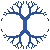

In [65]:
WIDTH = 50
IMAGE_RANGE = numpy.linspace(-1.0, 1.0, WIDTH)
v0_color = '#345eb7'
v1_color = '#345eb7'
v2_color = '#345eb7'
vcolors = [hex_to_rgb(x) for x in [v0_color, v1_color, v2_color]]

for frame in TIMELINE:
    
    max_iterations = round(frame['max_iterations'])
    p = frame['p']
    q = frame['q']
    r = frame['r']
    pqr = list(filter(bool, [p,q,r]))
    
    v0_tolerance = frame.get('v0_tolerance')
    v1_tolerance = frame.get('v1_tolerance')
    v2_tolerance = frame.get('v2_tolerance')
    vtolerances = [v0_tolerance, v1_tolerance, v2_tolerance]
    
    clear_output(wait=True)
    draw(pqr, WIDTH, IMAGE_RANGE, max_iterations, vcolors, vtolerances)